In [20]:
#!/usr/local/bin/python3.6

import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib

from matplotlib import pyplot
from scapy.all import * 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from scapy.all import *
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from sklearn import metrics


packets_validation = rdpcap('./pcap/feeding.pcapng')
#packets_testing = sniff(count=0,prn=None, lfilter=None, timeout=20,iface="wlp3s0",filter="port 80")
packets_feeding = rdpcap('./pcap/testing.pcapng')

In [21]:
#traitement des paquets ###############################################

#feeding tab ##########################################################

i = 0
feeding_tab = []
for y in range(len(packets_feeding)+1):
    feeding_tab.append(["" for y in range(27)])


for packet in packets_feeding:
    ###[ Ethernet ]###
    feeding_tab[i][0] = packet[0].dst
    feeding_tab[i][1] = packet[0].src
    feeding_tab[i][2] = packet[0].type
    ###[ IP ]###
    feeding_tab[i][3] = packet[1].version
    feeding_tab[i][4] = packet[1].ihl
    feeding_tab[i][5] = packet[1].tos
    feeding_tab[i][6] = packet[1].len
    feeding_tab[i][7] = packet[1].id
    feeding_tab[i][8] = packet[1].flags
    feeding_tab[i][9] = packet[1].frag
    feeding_tab[i][10] = packet[1].ttl
    feeding_tab[i][11] = packet[1].proto
    feeding_tab[i][12] = packet[1].chksum
    feeding_tab[i][13] = packet[1].src
    feeding_tab[i][14] = packet[1].dst
    ###[ TCP ]###
    feeding_tab[i][15] = packet[2].sport
    feeding_tab[i][16] = packet[2].dport
    feeding_tab[i][17] = packet[2].seq
    feeding_tab[i][18] = packet[2].ack
    feeding_tab[i][19] = packet[2].dataofs
    feeding_tab[i][20] = packet[2].reserved
    feeding_tab[i][21] = packet[2].flags
    feeding_tab[i][22] = packet[2].window
    feeding_tab[i][23] = packet[2].chksum
    feeding_tab[i][24] = packet[2].urgptr
    if packet[2].options is not None:
        feeding_tab[i][25] = packet[2].options
    else:
        feeding_tab[i][25] = '0'
    ###[ Raw ]###
    if "Raw" in packet:
        feeding_tab[i][26] = packet[3].load
    else:
        feeding_tab[i][26] = '0'

    i += 1

In [22]:
#validation tab ##########################################################

i = 0
validation_tab = []
for y in range(len(packets_validation)+1):
    validation_tab.append(["" for y in range(27)])


for packet in packets_validation:
    
    ###[ Ethernet ]###
    validation_tab[i][0] = packet[0].dst
    validation_tab[i][1] = packet[0].src
    validation_tab[i][2] = packet[0].type
    ###[ IP ]###
    validation_tab[i][3] = packet[1].version
    validation_tab[i][4] = packet[1].ihl
    validation_tab[i][5] = packet[1].tos
    validation_tab[i][6] = packet[1].len
    validation_tab[i][7] = packet[1].id
    validation_tab[i][8] = packet[1].flags
    validation_tab[i][9] = packet[1].frag
    validation_tab[i][10] = packet[1].ttl
    validation_tab[i][11] = packet[1].proto
    validation_tab[i][12] = packet[1].chksum
    validation_tab[i][13] = packet[1].src
    validation_tab[i][14] = packet[1].dst
    ###[ TCP ]###
    validation_tab[i][15] = packet[2].sport
    validation_tab[i][16] = packet[2].dport
    validation_tab[i][17] = packet[2].seq
    validation_tab[i][18] = packet[2].ack
    validation_tab[i][19] = packet[2].dataofs
    validation_tab[i][20] = packet[2].reserved
    validation_tab[i][21] = packet[2].flags
    validation_tab[i][22] = packet[2].window
    validation_tab[i][23] = packet[2].chksum
    validation_tab[i][24] = packet[2].urgptr
    if packet[2].options is not None:
        validation_tab[i][25] = packet[2].options
    else:
        validation_tab[i][25] = '0'
    ###[ Raw ]###
    if "Raw" in packet:
        validation_tab[i][26] = packet[3].load
    else:
        validation_tab[i][26] = '0'


    i += 1

In [24]:
count = 0
menace = 0
feeding_menace = []
for x in range(len(feeding_tab)):
    feeding_menace.append(0)

for packet in feeding_tab:
    if re.search('\.\.\/', str(packet)):
        feeding_menace[count] = 1
        count += 1
    elif re.search('Nikto', str(packet)):
        feeding_menace[count] = 1
        count += 1
    elif re.search('cmd=', str(packet)):
        feeding_menace[count] = 1
        count += 1
    elif re.search('%2F', str(packet)):
        feeding_menace[count] = 1
        count += 1
    elif re.search('passwd', str(packet)):
        feeding_menace[count] = 1
        count += 1
    else:
        feeding_menace[count] = 0
        count += 1
        menace += 1
        
print(menace)
print(count)

1788
8391


In [25]:
count = 0
menace = 0
validation_menace = []
for x in range(len(validation_tab)):
    validation_menace.append(0)

for packet in validation_tab:
    if re.search('\.\.\/', str(packet)):
        validation_menace[count] = 1
        count += 1
    elif re.search('Nikto', str(packet)):
        validation_menace[count] = 1
        count += 1
    elif re.search('cmd=', str(packet)):
        validation_menace[count] = 1
        count += 1
    elif re.search('%2F', str(packet)):
        validation_menace[count] = 1
        count += 1
    elif re.search('passwd', str(packet)):
        validation_menace[count] = 1
        count += 1
    else:
        validation_menace[count] = 0
        count += 1
        menace += 1
        
print(len(validation_tab))
print(len(validation_menace))

5273
5273


In [26]:

# tokenization des donnees #########################


def computeMD5hash(my_string):
    m = hashlib.md5()
    m.update(my_string.encode('utf-8'))
    digest = m.hexdigest()
    number = int(digest, 16)
    return number

X_train = np.zeros([len(packets_feeding)+1, 27])
X_test = np.zeros([len(packets_validation)+1, 27])



    


for i in range(len(X_train)):
    for j in range(27):
        text = feeding_tab[i][j]
        if str(text) == '' or str(0) == str(text):
            text = 0
        if type(text) == bytes:
            if re.match(b'\x00',text):
                text = 0
        elif type(text) == str:
            X_train[i][j] = computeMD5hash(text)

        elif type(text) == list or type(text) == bytes:
            text = ' '.join(map(str, feeding_tab[i][j]))
            X_train[i][j] = computeMD5hash(str(text))

        elif type(text) == int:
            X_train[i][j] = text
        

#################################################################
#################################################################

for i in range(len(X_test)):
    for j in range(27):
        text = validation_tab[i][j]
        if str(text) == '' or str(0) == str(text):
            text = 0
        if type(text) == bytes:
            if re.match(b'\x00',text):
                text = 0
        elif type(text) == str:
            X_test[i][j] = computeMD5hash(text)

        elif type(text) == list or type(text) == bytes:
            text = ' '.join(map(str, validation_tab[i][j]))
            X_test[i][j] = computeMD5hash(str(text))

        elif type(text) == int:
            X_test[i][j] = text
            



In [27]:
# reshape ########################################################

##################################################################

nb_classes = 2

X_train = np.array(X_train)
Y_train = np.array(feeding_menace )
X_test = np.array(X_test)
Y_test = np.array(validation_menace )



Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)





(8391, 27)
(8391, 2)
(5273, 27)
(5273, 2)


In [28]:
# création du modèle

model = Sequential()
model.add(Dense(2, input_shape=(27,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(2))
model.add(Dropout(0.2))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.


In [29]:
# compilation du model ###############################################

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Train on 8391 samples, validate on 5273 samples
Epoch 1/40
 - 1s - loss: 3.7169 - acc: 0.6867 - val_loss: 1.4394 - val_acc: 0.0453
Epoch 2/40
 - 0s - loss: 3.8404 - acc: 0.6824 - val_loss: 1.4887 - val_acc: 0.0453
Epoch 3/40
 - 0s - loss: 3.6384 - acc: 0.6946 - val_loss: 1.5393 - val_acc: 0.0453
Epoch 4/40
 - 0s - loss: 3.7333 - acc: 0.6890 - val_loss: 1.5857 - val_acc: 0.0453
Epoch 5/40
 - 0s - loss: 3.8352 - acc: 0.6870 - val_loss: 1.6323 - val_acc: 0.0453
Epoch 6/40
 - 0s - loss: 3.7558 - acc: 0.6875 - val_loss: 1.6658 - val_acc: 0.0453
Epoch 7/40
 - 0s - loss: 3.6863 - acc: 0.6929 - val_loss: 1.6973 - val_acc: 0.0453
Epoch 8/40
 - 0s - loss: 3.8304 - acc: 0.6873 - val_loss: 1.7263 - val_acc: 0.0453
Epoch 9/40
 - 0s - loss: 3.7733 - acc: 0.6859 - val_loss: 1.7501 - val_acc: 0.0453
Epoch 10/40
 - 0s - loss: 3.8035 - acc: 0.6870 - val_loss: 1.7683 - val_acc: 0.0453
Epoch 11/40
 - 0s - loss: 3.6617 - acc: 0.6978 - val_loss: 1.7882 - val_acc: 0.0453
Epoch 12/40
 - 0s - loss: 3.7236 - ac

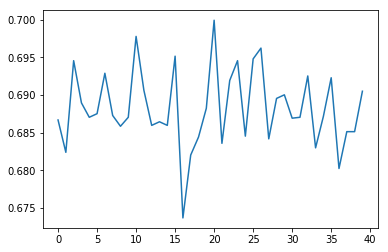

In [30]:
# training  ###############################################

history = model.fit(X_train, Y_train, batch_size=128, epochs=40, verbose=2,
         validation_data=(X_test, Y_test))
pyplot.plot(history.history['acc'])
pyplot.show()

In [33]:
# résultat ###############################################

#testing validation_tab ##########################################################

packets_testing = rdpcap('./pcap/sniffed2.pcap')

i = 0

    
validation_tab = []
for y in range(len(packets_validation)+1):
    validation_tab.append(["" for y in range(27)])


for packet in packets_testing:

    ###[ Ethernet ]###

    try:
        validation_tab[i][0] = packet[0].dst
    except:
        validation_tab[i][0] = '0'
            
    try:
        validation_tab[i][1] = packet[0].src
    except:
        validation_tab[i][1] = '0'

    try:
        validation_tab[i][2] = packet[0].type
    except: 
        validation_tab[i][2] = '0'


        ###[ IP ]###
    try:
        validation_tab[i][3] = packet[1].version
    except:
        validation_tab[i][3] = '0'

    try:
        validation_tab[i][4] = packet[1].ihl
    except:
        validation_tab[i][4] = '0'

    try:
        validation_tab[i][5] = packet[1].tos
    except:
        validation_tab[i][5] = '0'

    try:
        validation_tab[i][6] = packet[1].len
    except:
        validation_tab[i][6] = '0'

    try:
        validation_tab[i][7] = packet[1].id
    except:
        validation_tab[i][7] = '0'

    try:
        validation_tab[i][8] = packet[1].flags
    except:
        validation_tab[i][8] = '0'

    try:
        validation_tab[i][9] = packet[1].frag
    except:
        validation_tab[i][9] = '0'

    try:
        validation_tab[i][10] = packet[1].ttl
    except:
        validation_tab[i][10] = '0'

    try:
        validation_tab[i][11] = packet[1].proto
    except:
        validation_tab[i][11] = '0'

    try:
        validation_tab[i][12] = packet[1].chksum
    except:
        validation_tab[i][12] = '0'

    try:
        validation_tab[i][13] = packet[1].src
    except:
        validation_tab[i][13] = '0'

    try:
        validation_tab[i][14] = packet[1].dst
    except: 
        validation_tab[i][14] = '0'


        ###[ TCP ]###

    try:
        validation_tab[i][15] = packet[2].sport
    except:
        validation_tab[i][15] = '0'

    try:
        validation_tab[i][16] = packet[2].dport
    except:
        validation_tab[i][16] = '0'

    try:
        validation_tab[i][17] = packet[2].seq
    except:
        validation_tab[i][17] = '0'

    try:
        validation_tab[i][18] = packet[2].ack
    except:
        validation_tab[i][18] = '0'

    try:
        validation_tab[i][19] = packet[2].dataofs
    except:
        validation_tab[i][19] = '0'

    try:
        validation_tab[i][20] = packet[2].reserved
    except:
        validation_tab[i][20] = '0'

    try:
        validation_tab[i][21] = packet[2].flags
    except:
        validation_tab[i][21] = '0'

    try:
        validation_tab[i][22] = packet[2].window
    except:
        validation_tab[i][22] = '0'

    try:
        validation_tab[i][23] = packet[2].chksum
    except:
        validation_tab[i][23] = '0'

    try:
        validation_tab[i][24] = packet[2].urgptr
    except:
        validation_tab[i][24] = '0'

    try:
        validation_tab[i][25] = packet[2].options
    except:
        validation_tab[i][25] = '0'
    ###[ Raw ]###
    if "Raw" in packet:
        validation_tab[i][26] = packet[3].load
    else:
        validation_tab[i][26] = '0'

    i += 1


# tokenization ###########################################


Z_test = np.zeros([len(packets_testing)+1, 27])

for i in range(len(Z_test)):
    for j in range(27):
        text = testing_tab[i][j]
        if str(text) == '' or str(0) == str(text):
            text = 0
        if type(text) == bytes:
            if re.match(b'\x00',text):
                text = 0
        elif type(text) == str:
            Z_test[i][j] = computeMD5hash(text)

        elif type(text) == list or type(text) == bytes:
            text = ' '.join(map(str, testing_tab[i][j]))
            Z_test[i][j] = computeMD5hash(str(text))

        elif type(text) == int:
            Z_test[i][j] = text

##########################################################

predicted_classes = model.predict_classes(Z_test)
print(predicted_classes)
print(predicted_classes[52])
print(Z_test[52])


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1
b'\\\x93\xa2\xab\x96\xba0|\xb2\xa5!\xc6\x86\xdd`\x00\x9f=\x03J\x069 \x01\x0b\xc85\xb0\xc1f\x00\x00\x00\x00\x00\x00\x01Q*\x01\xcb\x05\x893p\x00\xe0\xad\x8b6\xce\xd4:\x00\x00P\x97\xfe\xf6@\x1a\x03\xdc\xe9\x1e8\x80\x18\x00\xfc\x9ch\x00\x00\x01\x01\x08\n\x00\xae\x1f:\x00\x14>\x83HTTP/1.1 200 OK\r\nServer: nginx\r\nDate: Sun, 26 Aug 2018 14:51:05 GMT\r\nContent-Type: text/html; charset=UTF-8\r\nTransfer-Encoding: chunked\r\nConnection: keep-alive\r\nVary: Accept-Encoding\r\nContent-Encoding: gzip\r\n\r\n24c\r\n\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03eS\xc1n\xdb0\x0c\xbd\xf7+\x18_\xd4\x0c\xab\xd5\x14\xdb\xa1\x99\xec\x01\xdd\x8av\x87mE\xd7K1\x0c\x83b3\xb6PY2$\xba\x99\xff~\x94\xddfi\xc7\x83MJ\xe2#\xf9\x9e\xa4\x16\x9f\xbf\x7f\xba\xbb\xbf\xb9\x84\x96:[\x1e\xa9\xf9\x07l\xaaE]\x97G\xc9M\xa6\xc

In [35]:
print(str(packets_testing[52]))
re.search('Nikto', str(packets_testing[52]))

b'\\\x93\xa2\xab\x96\xba0|\xb2\xa5!\xc6\x86\xdd`\x00\x9f=\x03J\x069 \x01\x0b\xc85\xb0\xc1f\x00\x00\x00\x00\x00\x00\x01Q*\x01\xcb\x05\x893p\x00\xe0\xad\x8b6\xce\xd4:\x00\x00P\x97\xfe\xf6@\x1a\x03\xdc\xe9\x1e8\x80\x18\x00\xfc\x9ch\x00\x00\x01\x01\x08\n\x00\xae\x1f:\x00\x14>\x83HTTP/1.1 200 OK\r\nServer: nginx\r\nDate: Sun, 26 Aug 2018 14:51:05 GMT\r\nContent-Type: text/html; charset=UTF-8\r\nTransfer-Encoding: chunked\r\nConnection: keep-alive\r\nVary: Accept-Encoding\r\nContent-Encoding: gzip\r\n\r\n24c\r\n\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03eS\xc1n\xdb0\x0c\xbd\xf7+\x18_\xd4\x0c\xab\xd5\x14\xdb\xa1\x99\xec\x01\xdd\x8av\x87mE\xd7K1\x0c\x83b3\xb6PY2$\xba\x99\xff~\x94\xddfi\xc7\x83MJ\xe2#\xf9\x9e\xa4\x16\x9f\xbf\x7f\xba\xbb\xbf\xb9\x84\x96:[\x1e\xa9\xf9\x07l\xaaE]\x97G\xc9M\xa6\xc8\x90\xc5\xf2\xfa\xee\xee\x06.t4UTr^\x9a\x8e(9\x1fO\x81\xda\xf8z,\x955\xee\x01\x02\xdaBD\x1a-\xc6\x16\x91\x04\xf4\xc1\xf7\x18h|\xb9jj\x8e\x05\xd0\xd8c!\x08\xff\x90\xac"\xc7m\xc0m!$a\xd7[M(c>-wX\x1b]\x08m\xad\